In [1]:
setwd("~/cdai/SpliFi/analysis")

In [2]:
suppressMessages(library(tidyverse))
suppressMessages(library(glue))
suppressMessages(library(data.table))

In [3]:
suppressMessages(library(cowplot))
suppressMessages(library(patchwork)) # ggplot2 extension for combining plots
library(ggtext)
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 180)
theme_set(theme_cowplot())


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [4]:
suppressMessages(library(furrr))
plan(multisession, workers = 6)

---

In [5]:
eqtl_nominal_file <- "../data/EQTLs/Geuvadis/steady_eqtl_nominal_frBen.txt.gz"
nom.cnames = scan(text = "phe_id phe_chr phe_from phe_to phe_strd n_var_in_cis dist_phe_var var_id var_chr var_from var_to nom_pval r_squared slope slope_se best_hit", what = "character")

In [6]:
sqtls <- fread("../data/CategorizeSplicingQTLs/Geuvadis/EUR.tsv")

In [7]:
sqtls %>% dim
sqtls[, .N, by = qtl_cl][, .(qtl_cl, N, P = round(N/sum(N), 3))]
sqtls %>% head(2) %>% print
sqtls$best_genotype_id %>% {glue("{length(unique(.))} unique top SNP ids")}

[1] 7341   25

qtl_cl,N,P
<chr>,<int>,<dbl>
u-sQTL,3693,0.503
p-sQTL,3648,0.497


                      phenotype_id phenotype_chr phenotype_start phenotype_end
1: chr1:954523:955922:clu_3265_-:N          chr1          954524        955922
2: chr1:999787:999865:clu_3266_-:F          chr1          999788        999865
   phenotype_strand num_variants best_nom_dist best_genotype_id
1:                -          539         -6023     1:961945:G:C
2:                -          575          1378     1:998410:G:A
   best_genotype_chr best_genotype_start best_genotype_end dof_true dof_est
1:              chr1              961945            961945      358 304.632
2:              chr1              998410            998410      358 303.478
   beta_ml1 beta_ml2    pval_nom   pval_r2     slope    pval_emp    pval_adj
1:  1.00545  61.9437 7.09513e-07 0.0664681 -0.865900 0.000999001 2.83335e-04
2:  1.02949  58.3234 2.42505e-09 0.0947773 -0.440919 0.000999001 1.55539e-06
            q   clu_id junc_cl clu_cl qtl_cl
1: 3.5028e-03 clu_3265       N    F,N u-sQTL
2: 2.8428e-05 clu_3266

7192 unique top SNP ids

In [8]:
#| label: funcs
queryNominal = function(var_id, tabixFile) {
  x = str_split(var_id, ":") %>% unlist
  x = glue("chr{x[1]}:{x[2]}-{x[2]}")
  cmd = glue("tabix {tabixFile} {x}")
  df = fread(cmd = cmd)
  if (nrow(df) > 0) {
    return(df)
  }
}

max_by_abs = function(v) {
  return(v[which.max(abs(v))])
}

In [9]:
# suppress warnings when a variant is not found and returns an empty data.table
# these are sQTL top SNPs eqtl nominal summary stats
eqtl_nom_stats <- suppressWarnings(
    future_map(unique(sqtls$best_genotype_id), ~queryNominal(.x, eqtl_nominal_file))
)

In [10]:
if (sum(sapply(eqtl_nom_stats, is.null)) > 0) {
    cat(glue("Note! {sum(sapply(eqtl_nom_stats, is.null))} out of {uniqueN(sqtls$best_genotype_id)} variants were not found in the eqtl_nominal_file\n"))
}

Note! 981 out of 7192 variants were not found in the eqtl_nominal_file

In [11]:
eqtl_nom_stats <- eqtl_nom_stats[which(!sapply(eqtl_nom_stats, is.null))] %>% 
    rbindlist
setnames(eqtl_nom_stats, nom.cnames)


In [12]:
dim(eqtl_nom_stats)
eqtl_nom_stats %>% head(2) %>% print

[1] 31516    16

                                  phe_id phe_chr phe_from  phe_to phe_strd
1: ENSG00000187583.11:ENSG00000187583.11    chr1   866482 1075865        +
2: ENSG00000187608.10:ENSG00000187608.10    chr1   901138 1114540        +
   n_var_in_cis dist_phe_var       var_id var_chr var_from var_to nom_pval
1:         1439            0 1:961945:G:C    chr1   961945 961945 0.218277
2:         1456            0 1:961945:G:C    chr1   961945 961945 0.256842
    r_squared      slope  slope_se best_hit
1: 0.00338879  0.0661908 0.0536889        0
2: 0.00287536 -0.0322626 0.0284167        0


In [13]:
(length(intersect(eqtl_nom_stats$var_id, sqtls$best_genotype_id)) /
    uniqueN(sqtls$best_genotype_id))  %>%
    scales::percent(., accuracy = 1) %>% 
    {glue("{.} of sQTL top SNPs are in eQTL nominal summary stats")} %>% print


86% of sQTL top SNPs are in eQTL nominal summary stats


---

## sQTL enrichment in eQTL pvalues

In [65]:
cols1 <- c("phe_id", "phe_chr", "phe_from", "phe_to", "phe_strd", "var_id", "nom_pval", "slope")
cols2  <- c("phenotype_id", "phenotype_chr", "phenotype_start", "phenotype_end", "phenotype_strand", "best_genotype_id", "pval_nom", "slope", "junc_cl", "qtl_cl")

In [68]:
eqtl_nom_stats[1:2, ..cols1] %>% print
cat('\n\n')
sqtls[1:2, ..cols2] %>% print

                                  phe_id phe_chr phe_from  phe_to phe_strd
1: ENSG00000187583.11:ENSG00000187583.11    chr1   866482 1075865        +
2: ENSG00000187608.10:ENSG00000187608.10    chr1   901138 1114540        +
         var_id nom_pval      slope
1: 1:961945:G:C 0.218277  0.0661908
2: 1:961945:G:C 0.256842 -0.0322626


                      phenotype_id phenotype_chr phenotype_start phenotype_end
1: chr1:954523:955922:clu_3265_-:N          chr1          954524        955922
2: chr1:999787:999865:clu_3266_-:F          chr1          999788        999865
   phenotype_strand best_genotype_id    pval_nom     slope junc_cl qtl_cl
1:                -     1:961945:G:C 7.09513e-07 -0.865900       N u-sQTL
2:                -     1:998410:G:A 2.42505e-09 -0.440919       F p-sQTL


In [69]:
joined_dt <- inner_join(eqtl_nom_stats[, ..cols1], sqtls[, ..cols2], 
           by = c("var_id" = "best_genotype_id"), suffix = c("_eqtl", "_sqtls"),
           relationship = "many-to-many"
           )

In [70]:
dim(joined_dt) %>% print

joined_dt %>% head(5) %>% print

[1] 27159    17
                                  phe_id phe_chr phe_from  phe_to phe_strd
1: ENSG00000187583.11:ENSG00000187583.11    chr1   866482 1075865        +
2: ENSG00000187608.10:ENSG00000187608.10    chr1   901138 1114540        +
3: ENSG00000187961.14:ENSG00000187961.14    chr1   860584 1065719        +
4: ENSG00000188157.15:ENSG00000188157.15    chr1   920120 1156118        +
5: ENSG00000188290.11:ENSG00000188290.11    chr1   898962 1100172        -
         var_id    nom_pval  slope_eqtl                    phenotype_id
1: 1:961945:G:C 0.218277000  0.06619080 chr1:954523:955922:clu_3265_-:N
2: 1:961945:G:C 0.256842000 -0.03226260 chr1:954523:955922:clu_3265_-:N
3: 1:961945:G:C 0.000180183  0.12634100 chr1:954523:955922:clu_3265_-:N
4: 1:961945:G:C 0.286904000 -0.02460500 chr1:954523:955922:clu_3265_-:N
5: 1:961945:G:C 0.853179000 -0.00723308 chr1:954523:955922:clu_3265_-:N
   phenotype_chr phenotype_start phenotype_end phenotype_strand    pval_nom
1:          chr1          

Notice the join on variant ID between sQTL and nominal eQTL stats is a many-to-many relationship. This means that a single sQTL variant can be associated with multiple eQTLs, and vice versa. This is because a single sQTL variant can be associated with multiple genes, and a single gene can be associated with multiple sQTL variants.

**On average how many sQTLs is a gene associated with? How many genes is a sQTL variant associated with?**

In [18]:
m1 <- joined_dt[, .(N = length(phenotype_id)), by = phe_id][, N] %>% median
m2 <- joined_dt[, .(N = length(phe_id)), by = phenotype_id][, N] %>% median

In [19]:
# how many sQTLs is a gene associated with?
p1  <- joined_dt[, .(N = length(phenotype_id)), by = phe_id] %>% 
    ggplot() + geom_histogram(aes(x = N), bins = 20, color = 'white') +
        geom_vline(xintercept = m1, color = "red", linetype = "dashed") +
        scale_x_continuous(breaks = seq(0, 100, 2)) +
        lims(y = c(0, 3500)) + 
        labs(x = "Number of sQTLs", 
             title = "Number of sQTL-associtated *introns*<br>a gene paired with") +
        theme(plot.title = element_markdown())

# How many genes is a sQTL variant associated with?
p2  <- joined_dt[, .(N = length(phe_id)), by = phenotype_id] %>% 
    ggplot() + geom_histogram(aes(x = N), bins = 20, color = 'white') +
        geom_vline(xintercept = m2, color = "red", linetype = "dashed") +
        scale_x_continuous(breaks = seq(0, 100, 2)) +
        lims(y = c(0, 3500)) + 
        labs(x = "Number of genes", 
             title = "Number of *genes* an sQTL-associated<br>intron paired with") +
        theme(plot.title = element_markdown())

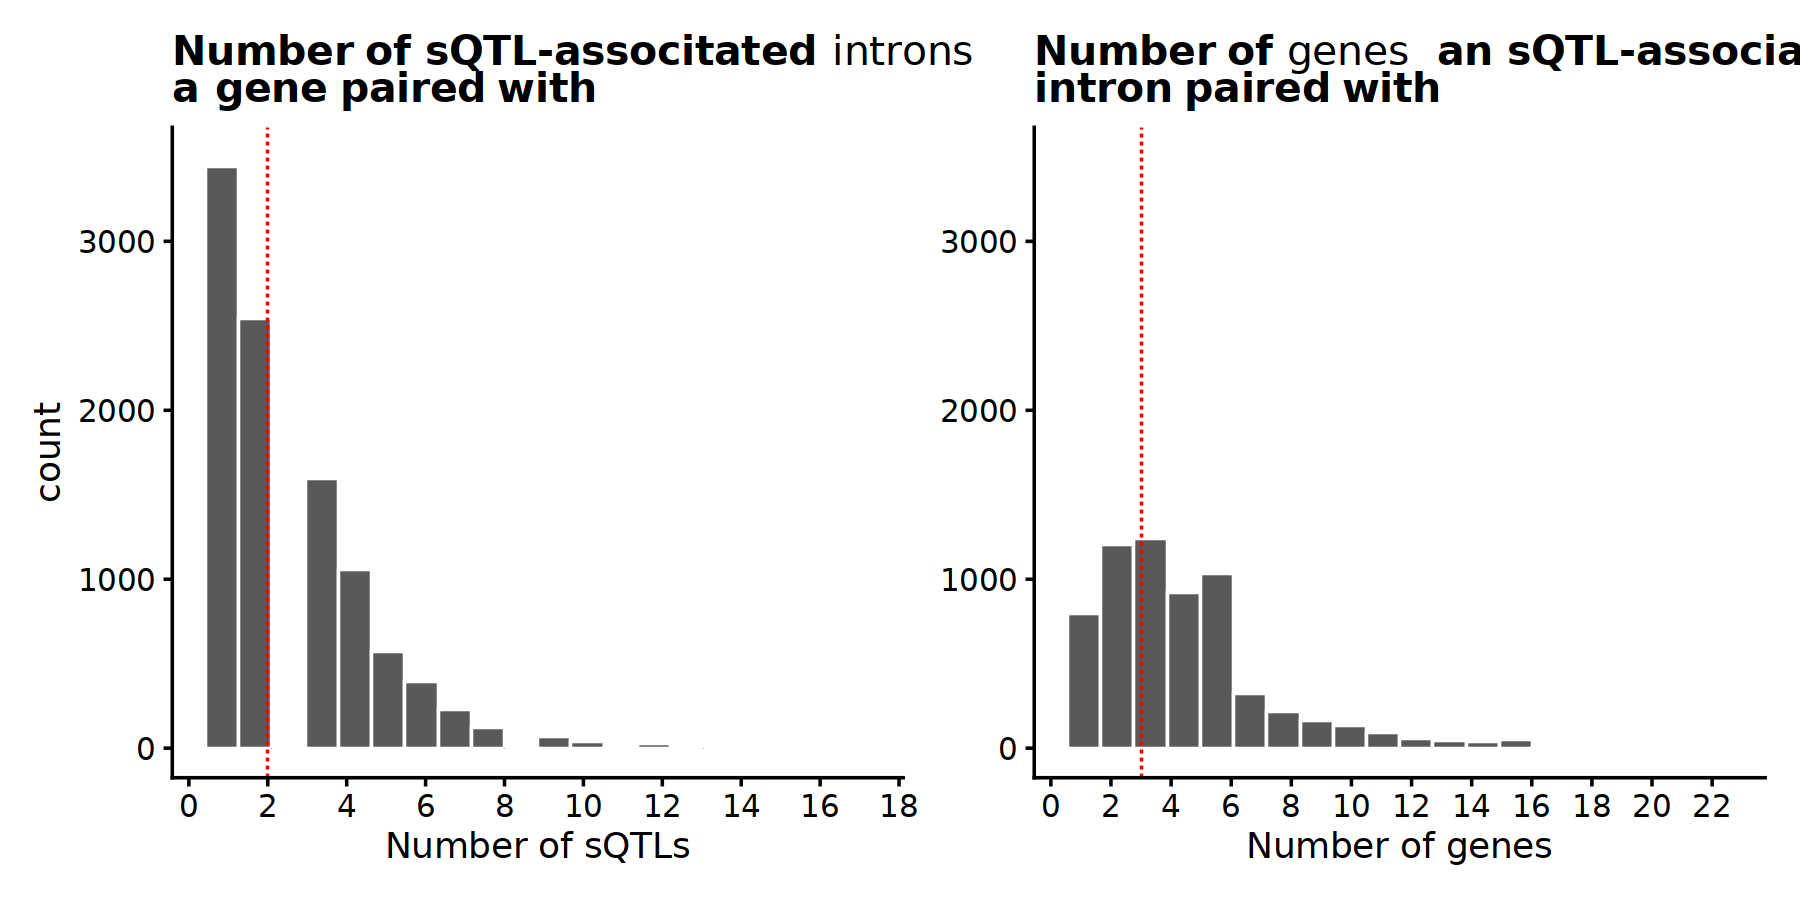

In [20]:
# collect axis titles
p1 + p2 +   plot_layout(axis_titles = "collect")

---

## Enrichment of sQTL top variants' p-values in eQTL nominal stats




In [104]:
joined_dt %>% head(5) %>% print

                                  phe_id phe_chr phe_from  phe_to phe_strd
1: ENSG00000187583.11:ENSG00000187583.11    chr1   866482 1075865        +
2: ENSG00000187608.10:ENSG00000187608.10    chr1   901138 1114540        +
3: ENSG00000187961.14:ENSG00000187961.14    chr1   860584 1065719        +
4: ENSG00000188157.15:ENSG00000188157.15    chr1   920120 1156118        +
5: ENSG00000188290.11:ENSG00000188290.11    chr1   898962 1100172        -
         var_id    nom_pval  slope_eqtl                    phenotype_id
1: 1:961945:G:C 0.218277000  0.06619080 chr1:954523:955922:clu_3265_-:N
2: 1:961945:G:C 0.256842000 -0.03226260 chr1:954523:955922:clu_3265_-:N
3: 1:961945:G:C 0.000180183  0.12634100 chr1:954523:955922:clu_3265_-:N
4: 1:961945:G:C 0.286904000 -0.02460500 chr1:954523:955922:clu_3265_-:N
5: 1:961945:G:C 0.853179000 -0.00723308 chr1:954523:955922:clu_3265_-:N
   phenotype_chr phenotype_start phenotype_end phenotype_strand    pval_nom
1:          chr1          954524        95

In [42]:
multiqq <- function(pvalues) {

  punif <- -log10(runif(max(sapply(pvalues, length))))

  df <- future_map_dfr(seq_along(pvalues), ~{
    i <- .x
    df <- as.data.frame(qqplot(punif[1:length(pvalues[[i]])], -log10(pvalues[[i]]), plot.it = FALSE))
    if (is.null(names(pvalues))) {
      cat("Warning: pvalues must be a named list\n")
      # break out of the function
      return(NULL)
      }
    df$group <- names(pvalues)[i]
    df
  })

  df$group <- factor(df$group, levels = names(pvalues))

  ggplot(df, aes(x, y, col = group)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1) +
    theme_bw(base_size = 18) +
    xlab("Expected -log10(p)") +
    ylab("Observed -log10(p)")
}

In [164]:
qq1 = joined_dt[incl_index, .(nom_pval, qtl_cl)] %>% split(by = 'qtl_cl') %>%
    map(\(x) x[, nom_pval]) %>% multiqq
qq1 = qq1 + theme_set(theme_cowplot())

# rasterize the points using ggrastr

qq1 = ggrastr::rasterize(qq1, layers='Point', dpi=100)

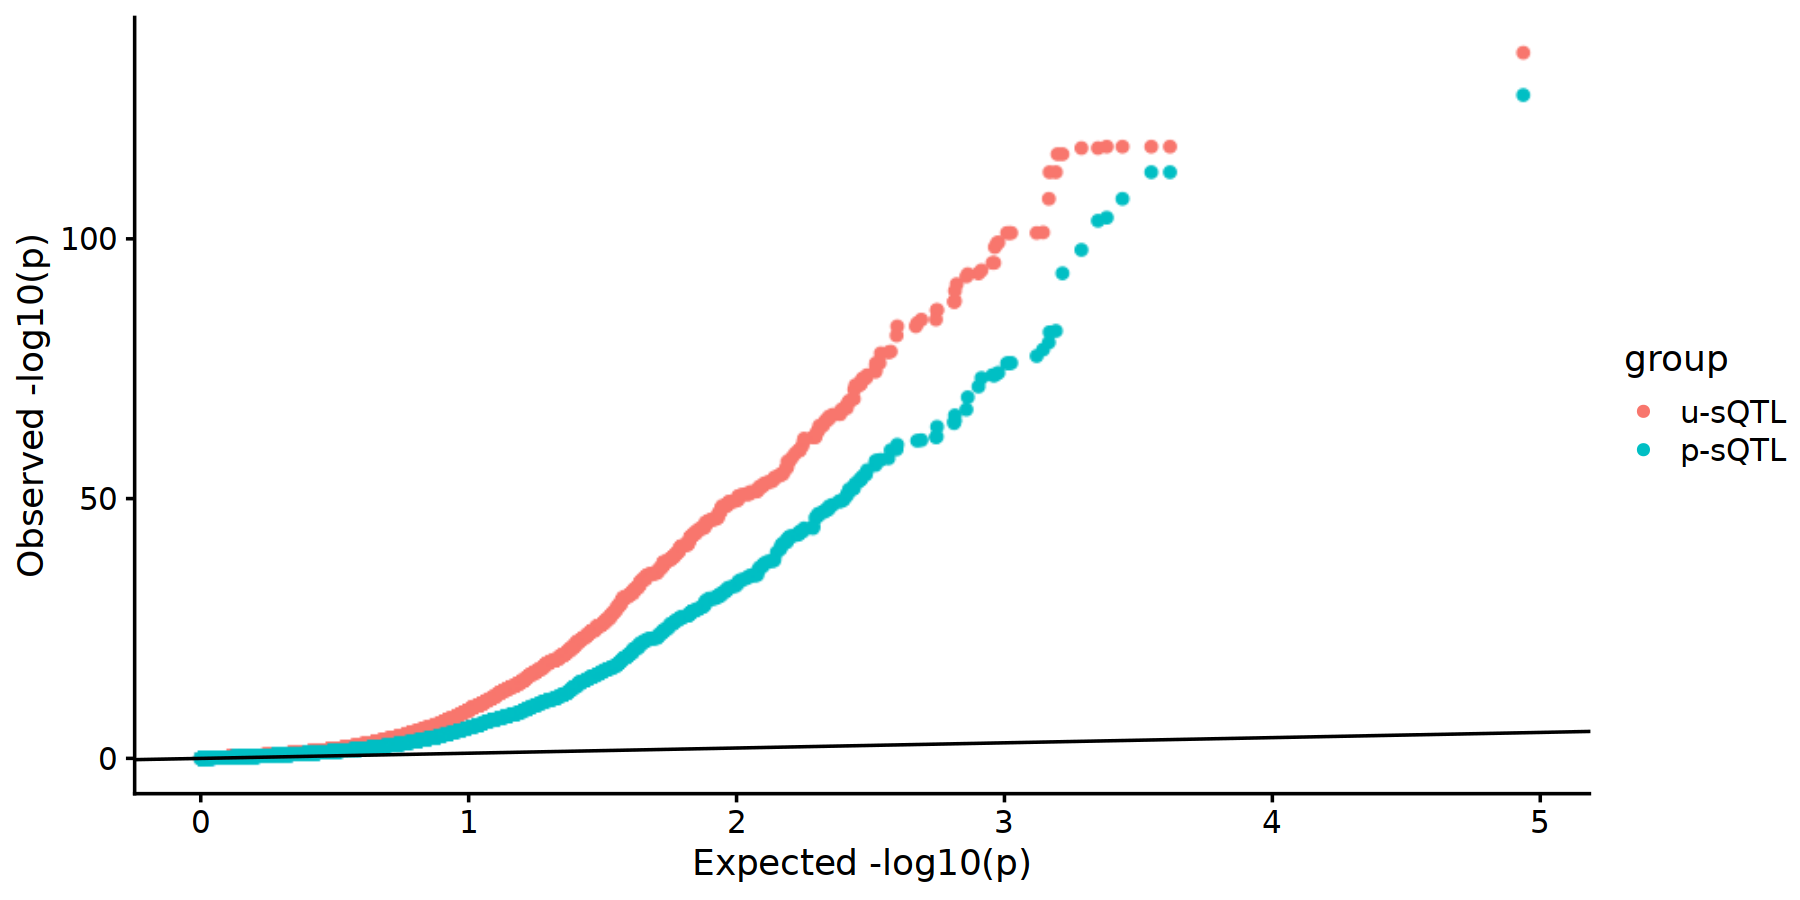

In [165]:
qq1

---


## Effect size of sQTLs top variants in expression QTL nominal stats

In [75]:
suppressMessages(library(GenomicRanges))

In [100]:
joined_dt[1:5, 2:5]

phe_chr,phe_from,phe_to,phe_strd
<chr>,<int>,<int>,<chr>
chr1,866482,1075865,+
chr1,901138,1114540,+
chr1,860584,1065719,+
chr1,920120,1156118,+
chr1,898962,1100172,-


In [137]:
r1 <- joined_dt[, 9:13][, .(phenotype_id, rgs = paste(phenotype_chr, ":", phenotype_start, "-", phenotype_end, sep = "") )]
r1 <- GRanges(r1$rgs)
r2 <- joined_dt[, 1:5][, .(phe_id, rgs = paste(phe_chr, ":", phe_from, "-", phe_to, sep = ""))]
r2 <- GRanges(r2$rgs)


In [139]:
r1
r2

GRanges object with 27159 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     954524-955922      *
      [2]     chr1     954524-955922      *
      [3]     chr1     954524-955922      *
      [4]     chr1     954524-955922      *
      [5]     chr1     954524-955922      *
      ...      ...               ...    ...
  [27155]    chr22 50626761-50627165      *
  [27156]    chr22 50626761-50627165      *
  [27157]    chr22 50626761-50627165      *
  [27158]    chr22 50782348-50783500      *
  [27159]    chr22 50782348-50783500      *
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

GRanges object with 27159 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1    866482-1075865      *
      [2]     chr1    901138-1114540      *
      [3]     chr1    860584-1065719      *
      [4]     chr1    920120-1156118      *
      [5]     chr1    898962-1100172      *
      ...      ...               ...    ...
  [27155]    chr22 50574415-50818468      *
  [27156]    chr22 50468869-50682965      *
  [27157]    chr22 50423568-50626461      *
  [27158]    chr22 50667501-50818468      *
  [27159]    chr22 50574415-50818468      *
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

In [145]:
d <- future_map_int(seq_along(r1), \(x) {
    distance(r1[x], r2[x])
}
)

In [162]:
incl_index = which(d == 0)

In [163]:
joined_dt[incl_index] %>% dim
joined_dt[incl_index] %>% head %>% print

[1] 24707    17

                                  phe_id phe_chr phe_from  phe_to phe_strd
1: ENSG00000187583.11:ENSG00000187583.11    chr1   866482 1075865        +
2: ENSG00000187608.10:ENSG00000187608.10    chr1   901138 1114540        +
3: ENSG00000187961.14:ENSG00000187961.14    chr1   860584 1065719        +
4: ENSG00000188157.15:ENSG00000188157.15    chr1   920120 1156118        +
5: ENSG00000188290.11:ENSG00000188290.11    chr1   898962 1100172        -
6: ENSG00000188976.11:ENSG00000188976.11    chr1   844203 1059309        -
         var_id    nom_pval  slope_eqtl                    phenotype_id
1: 1:961945:G:C 0.218277000  0.06619080 chr1:954523:955922:clu_3265_-:N
2: 1:961945:G:C 0.256842000 -0.03226260 chr1:954523:955922:clu_3265_-:N
3: 1:961945:G:C 0.000180183  0.12634100 chr1:954523:955922:clu_3265_-:N
4: 1:961945:G:C 0.286904000 -0.02460500 chr1:954523:955922:clu_3265_-:N
5: 1:961945:G:C 0.853179000 -0.00723308 chr1:954523:955922:clu_3265_-:N
6: 1:961945:G:C 0.006448710 -0.08218350 chr

In [156]:
summary(d)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0    2578       0   97615 

In [ ]:
joined_dt[incl_index] %>% head %>% print

[1] 24707    17

                                  phe_id phe_chr phe_from  phe_to phe_strd
1: ENSG00000187583.11:ENSG00000187583.11    chr1   866482 1075865        +
2: ENSG00000187608.10:ENSG00000187608.10    chr1   901138 1114540        +
3: ENSG00000187961.14:ENSG00000187961.14    chr1   860584 1065719        +
4: ENSG00000188157.15:ENSG00000188157.15    chr1   920120 1156118        +
5: ENSG00000188290.11:ENSG00000188290.11    chr1   898962 1100172        -
6: ENSG00000188976.11:ENSG00000188976.11    chr1   844203 1059309        -
         var_id    nom_pval  slope_eqtl                    phenotype_id
1: 1:961945:G:C 0.218277000  0.06619080 chr1:954523:955922:clu_3265_-:N
2: 1:961945:G:C 0.256842000 -0.03226260 chr1:954523:955922:clu_3265_-:N
3: 1:961945:G:C 0.000180183  0.12634100 chr1:954523:955922:clu_3265_-:N
4: 1:961945:G:C 0.286904000 -0.02460500 chr1:954523:955922:clu_3265_-:N
5: 1:961945:G:C 0.853179000 -0.00723308 chr1:954523:955922:clu_3265_-:N
6: 1:961945:G:C 0.006448710 -0.08218350 chr

In [180]:
library(magrittr)

In [190]:
corr_test <- joined_dt[incl_index, .(slope_sqtls, slope_eqtl, qtl_cl)] %>% 
    split(by = 'qtl_cl') %>% 
    map(~cor.test(.$slope_sqtls, .$slope_eqtl, method = 'spearman'))

Warning message in cor.test.default(.$slope_sqtls, .$slope_eqtl, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(.$slope_sqtls, .$slope_eqtl, method = "spearman"):
“Cannot compute exact p-value with ties”


In [194]:
corr_pval <- corr_test %>% map_dbl(\(x) x$p.value)
corr_est <- corr_test %>% map_dbl(\(x) x$estimate)

In [ ]:
corr_pval

: 

In [197]:
print(corr_pval)
print(corr_est)

      u-sQTL       p-sQTL 
4.510947e-27 1.394711e-08 
     u-sQTL      p-sQTL 
-0.09571328 -0.05157660 


`geom_smooth()` using formula = 'y ~ x'


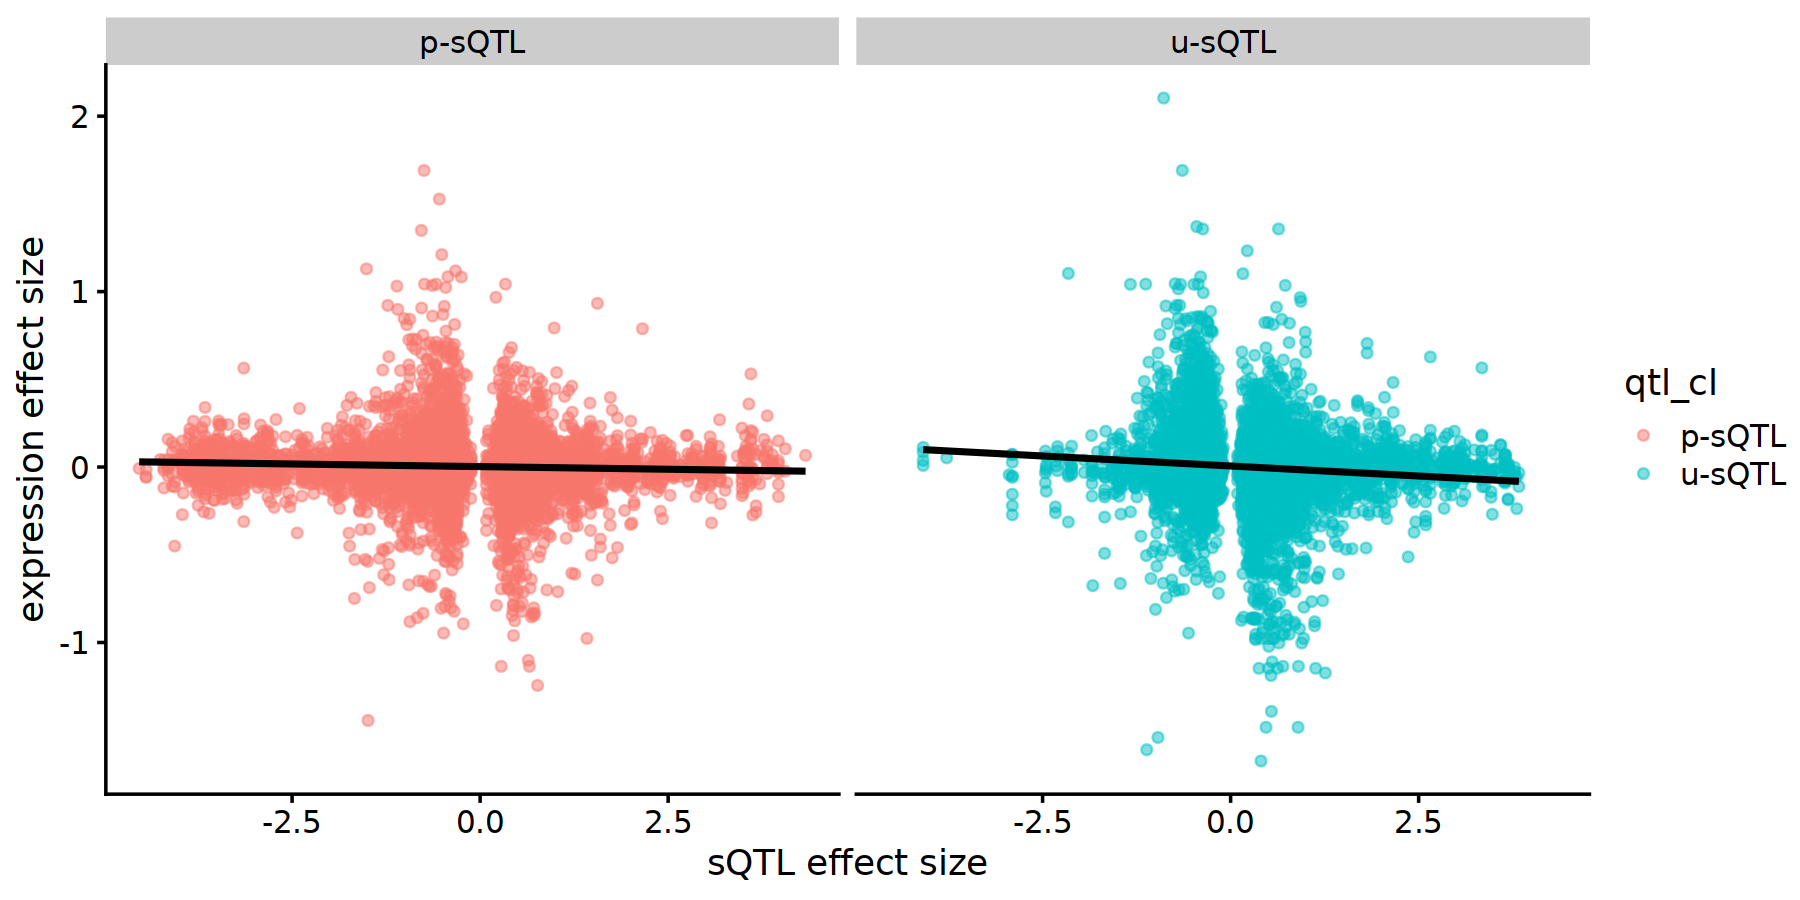

In [171]:
joined_dt[incl_index]  %>% 
    ggplot() + geom_point(aes(x = slope_sqtls, y = slope_eqtl, color = qtl_cl), alpha = .5) +   
        geom_smooth(aes(x = slope_sqtls, y = slope_eqtl), color = "black", method = "lm", se = FALSE) +
        labs(x = "sQTL effect size", y = "expression effect size") +
        facet_wrap(~qtl_cl, ncol = 2)